In [ ]:
# default_exp models.esrnn.esrnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ES-RNN: Exponential Smoothing Recurrent Neural Network

> API details.

The winning submission of the M4 competition was the <em>Exponential Smoothing Recurrent Neural Network</em> (ESRNN). This hybrid model combined and simultaneously optimized the standard exponential smoothing method as a preprocessing component for the inputs of recurrent neural networks. The [original model](https://github.com/Mcompetitions/M4-methods/tree/master/118%20-%20slaweks17) is implemented in dynet.

[Slawek Smyl. A hybrid method of exponential smoothing and recurrent neural networks for time series forecasting. International Journal of Forecasting, 07 2019.](https://www.sciencedirect.com/science/article/pii/S0169207019301153)

In [ ]:
#export
import numpy as np
import torch as t
import torch.nn as nn

from nixtlats.models.components.drnn import DRNN

In [ ]:
#export
#TODO: rnn con canales
#TODO: notacion de todo, windows_y_insample
class _ES(nn.Module):
    def __init__(self, 
                 n_series: int, 
                 input_size: int,
                 output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ES, self).__init__()

        self.n_series = n_series
        self.input_size = input_size
        self.output_size = output_size
        self.output_size_m = output_size_m
        self.n_t = n_t
        self.n_s = n_s
        self.seasonality = seasonality
        assert len(self.seasonality) in [0, 1, 2]

        self.noise_std = noise_std

    def gaussian_noise(self, Y: t.Tensor, std: float=0.2):
        size = Y.size()
        noise = t.autograd.Variable(Y.data.new(size).normal_(0, std))
        return Y + noise

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        pass

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor, start: int, end: int):
        pass

    def predict(self, trend: t.Tensor, levels: t.Tensor, seasonalities: t.Tensor):
        pass

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                idxs: t.Tensor, sample_mask: t.Tensor):
        # parse attributes
        input_size = self.input_size
        output_size = self.output_size
        n_t = self.n_t
        n_s = self.n_s
        context_size = input_size + (input_size+output_size)*n_t + n_s
        noise_std = self.noise_std
        seasonality = self.seasonality
        batch_size = len(idxs)

        n_series, n_time = Y.shape

        # Explicacion: windows_end es el idx delultimo inicio de windows. Como se necesitan windows completas con input
        # + output, se pierden (input_size+output_size-1) windows del len total de la serie.
        windows_end = n_time - input_size - output_size + 1
        #windows_range = range(0, windows_end, step_size)
        windows_range = range(0, windows_end)
        n_windows = len(windows_range)
        
        assert n_windows>0

        # Initialize windows, levels and seasonalities
        levels, seasonalities = self.compute_levels_seasons(Y=Y, idxs=idxs)
        windows_y_insample = t.zeros((n_windows, batch_size, context_size),
                                     device=Y.device)
        windows_y_outsample = t.zeros((n_windows, batch_size, output_size),
                                      device=Y.device)

        for i, window in enumerate(windows_range):
            # Windows yhat
            y_insample_start = window
            y_insample_end   = input_size + window

            # Y_hat deseasonalization and normalization
            window_y_insample = self.normalize(Y=Y[:, y_insample_start:y_insample_end],
                                               level=levels[:, [y_insample_end-1]],
                                               seasonalities=seasonalities,
                                               start=y_insample_start, end=y_insample_end) #TODO: improve this inputs

            if self.training:
                window_y_insample = self.gaussian_noise(window_y_insample, std=noise_std)

            if n_t > 0:
                window_x_t = X[:, :, y_insample_start:(y_insample_end+output_size)]
                window_x_t = window_x_t.reshape(batch_size, -1)
                window_y_insample = t.cat((window_y_insample, window_x_t), 1)

            # Concatenate S static variables matrix
            if n_s > 0:
                window_y_insample = t.cat((window_y_insample, S), 1)

            windows_y_insample[i, :, :] += window_y_insample

            # Windows_y_outsample
            y_outsample_start = y_insample_end
            y_outsample_end = y_outsample_start + output_size
            window_y_outsample = Y[:, y_outsample_start:y_outsample_end]
            # If training, normalize outsample for loss on normalized data
            if self.training:
                # Y deseasonalization and normalization
                window_y_outsample = self.normalize(Y=window_y_outsample,
                                                    level=levels[:, [y_outsample_start]],
                                                    seasonalities=seasonalities,
                                                    start=y_outsample_start, end=y_outsample_end) #TODO: improve this inputs
            windows_y_outsample[i, :, :] += window_y_outsample
        
        
        # Wrangles the sample_mask with same indexes as windows_y_outsample
        n_windows, n_batch, n_output = windows_y_outsample.shape
        sample_mask = sample_mask.unfold(dimension=-1, size=self.output_size, step=1)
        sample_mask = sample_mask[:, -n_windows:, :]
        sample_mask = sample_mask.permute(1,0,2)
        
        return windows_y_insample, windows_y_outsample, levels, seasonalities, sample_mask

In [ ]:
#export
class _ESI(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ESI, self).__init__(n_series, input_size, output_size, 
                                   output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        self.W = t.nn.Parameter(t.randn(1))
        self.W.requires_grad = False

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        levels = t.ones(Y.shape, device=Y.device)
        seasonalities = None
        return levels, None
    
    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor, 
                  start: int, end: int):
        return Y

    def predict(self, 
                trends: t.Tensor, 
                levels: t.Tensor, 
                seasonalities: t.Tensor):
        return trends

In [ ]:
#export
class _MedianResidual(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int, 
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_MedianResidual, self).__init__(n_series, input_size, output_size, output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        self.W = t.nn.Parameter(t.randn(1))
        self.W.requires_grad = False

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        """
        Computes levels and seasons
        """
        y_transformed, _ = Y.median(1)
        y_transformed = y_transformed.reshape(-1, 1)
        levels = y_transformed.repeat(1, Y.shape[1])
        seasonalities = None
        
        return levels, None
    
    def normalize(self, Y: t.Tensor, level: t.Tensor, 
                  seasonalities: t.Tensor, 
                  start: int, end: int):
        
        return Y - level

    def predict(self, 
                trends: t.Tensor, 
                levels: t.Tensor, 
                seasonalities: t.Tensor):
        levels = levels[:, (self.input_size-1):-self.output_size]
        levels = levels.unsqueeze(2)

        return trends + levels

In [ ]:
#export
class _ESM(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ESM, self).__init__(n_series, input_size, output_size, 
                                   output_size_m, 
                                   n_t, n_s, seasonality, noise_std)
        # Level and Seasonality Smoothing parameters
        # 1 level, S seasonalities, S init_seas
        embeds_size = 1 + len(self.seasonality) + sum(self.seasonality)
        init_embeds = t.ones((self.n_series, embeds_size)) * 0.5
        self.embeds = nn.Embedding(self.n_series, embeds_size)
        self.embeds.weight.data.copy_(init_embeds)
        self.seasonality = t.LongTensor(self.seasonality)

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        """
        Computes levels and seasons
        """
        # Lookup parameters per serie
        #seasonality = self.seasonality
        embeds = self.embeds(idxs)
        lev_sms = t.sigmoid(embeds[:, 0])

        # Initialize seasonalities
        seas_prod = t.ones(len(Y[:,0]), device=Y.device)
        seasonalities1 = []
        seasonalities2 = []
        seas_sms1 = t.ones(1, device=Y.device)
        seas_sms2 = t.ones(1, device=Y.device)

        if len(self.seasonality)>0:
            seas_sms1 = t.sigmoid(embeds[:, 1])
            init_seas1 = t.exp(embeds[:, 2:(2+self.seasonality[0])]).unbind(1)
            assert len(init_seas1) == self.seasonality[0]

            for i in range(len(init_seas1)):
                seasonalities1 += [init_seas1[i]]
            seasonalities1 += [init_seas1[0]]
            seas_prod = seas_prod * init_seas1[0]

        if len(self.seasonality)==2:
            seas_sms2 = t.sigmoid(embeds[:, 2+self.seasonality[0]])
            init_seas2 = t.exp(embeds[:, 3+self.seasonality[0]:]).unbind(1)
            assert len(init_seas2) == self.seasonality[1]

            for i in range(len(init_seas2)):
                seasonalities2 += [init_seas2[i]]
            seasonalities2 += [init_seas2[0]]
            seas_prod = seas_prod * init_seas2[0]

        # Initialize levels
        levels = []
        levels += [Y[:,0]/seas_prod]

        # Recursive seasonalities and levels
        ys = Y.unbind(1)
        n_time = len(ys)
        for t_idx in range(1, n_time):
            seas_prod_t = t.ones(len(Y[:,t_idx]), device=Y.device)
            if len(self.seasonality)>0:
                seas_prod_t = seas_prod_t * seasonalities1[t_idx]
            if len(self.seasonality)==2:
                seas_prod_t = seas_prod_t * seasonalities2[t_idx]

            newlev = lev_sms * (ys[t_idx] / seas_prod_t) + (1-lev_sms) * levels[t_idx-1]
            levels += [newlev]

            if len(self.seasonality)==1:
                newseason1 = seas_sms1 * (ys[t_idx] / newlev) + (1-seas_sms1) * seasonalities1[t_idx]
                seasonalities1 += [newseason1]

            if len(self.seasonality)==2:
                newseason1 = seas_sms1 * (ys[t_idx] / (newlev * seasonalities2[t_idx])) + \
                                         (1-seas_sms1) * seasonalities1[t_idx]
                seasonalities1 += [newseason1]
                newseason2 = seas_sms2 * (ys[t_idx] / (newlev * seasonalities1[t_idx])) + \
                                         (1-seas_sms2) * seasonalities2[t_idx]
                seasonalities2 += [newseason2]

        levels = t.stack(levels).transpose(1,0)

        seasonalities = []

        if len(self.seasonality)>0:
            seasonalities += [t.stack(seasonalities1).transpose(1,0)]

        if len(self.seasonality)==2:
            seasonalities += [t.stack(seasonalities2).transpose(1,0)]

        return levels, seasonalities

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor, 
                  start: int, end: int):
        # Deseasonalization and normalization
        y_n = Y / level
        for s in range(len(self.seasonality)):
            y_n /= seasonalities[s][:, start:end]
        y_n = t.log(y_n)
        return y_n

    def predict(self, trends: t.Tensor, levels: t.Tensor, seasonalities: t.Tensor):

        # First trend uses last value of first y_insample of length self.input_size.
        # Last self.output_size levels are not used (leakeage!!!)
        levels = levels[:, (self.input_size-1):-self.output_size]
        levels = levels.unsqueeze(2)

        # Seasonalities are unfolded, because each element of trends must be multiplied
        # by the corresponding seasonality.
        for i in range(len(seasonalities)):
            seasonalities[i] = seasonalities[i][:, self.seasonality[i]:]
            seasonalities[i] = seasonalities[i].unfold(dimension=-1, 
                                                       size=self.input_size + self.output_size,
                                                       step=1)
            seasonalities[i] = seasonalities[i][:,:,:self.input_size] #avoid leakage
            
            # Fill seasonalities with NaiveSeasonal, to avoid leakage.
            if self.output_size > seasonalities[i].shape[2]:
                repetitions = int(np.ceil(self.output_size / seasonalities[i].shape[2]))
                seasonalities[i] = seasonalities[i].repeat((1, 1, repetitions))
            seasonalities[i] = seasonalities[i][:, :, :self.output_size]

        # Denormalize
        trends = t.exp(trends)
        # Deseasonalization and normalization (inverse)
        y_hat = trends * levels
        for s in range(len(self.seasonality)):
            seas = seasonalities[s]
            y_hat *= t.vstack([seas.T for _ in range(self.output_size_m)]).T

        return y_hat

In [ ]:
#export
class _RNN(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, cell_type: str, dilations: list, state_hsize: int, add_nl_layer: bool):
        super(_RNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_size_m = output_size_m
        self.n_t = n_t
        self.n_s = n_s

        self.cell_type = cell_type
        self.dilations = dilations
        self.state_hsize = state_hsize
        self.add_nl_layer = add_nl_layer
        self.layers = len(dilations)

        layers = []
        for grp_num in range(len(self.dilations)):
            if grp_num == 0:
                input_size = self.input_size + (self.input_size + self.output_size)*self.n_t + self.n_s
            else:
                input_size = self.state_hsize
            layer = DRNN(input_size,
                         self.state_hsize,
                         n_layers=len(self.dilations[grp_num]),
                         dilations=self.dilations[grp_num],
                         cell_type=self.cell_type)
            layers.append(layer)

        self.rnn_stack = nn.Sequential(*layers)

        if self.add_nl_layer:
            self.MLPW  = nn.Linear(self.state_hsize, self.state_hsize)

        self.adapterW  = nn.Linear(self.state_hsize, self.output_size * self.output_size_m)

    def forward(self, input_data: t.Tensor):
        for layer_num in range(len(self.rnn_stack)):
            residual = input_data
            output, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                output += residual
            input_data = output

        if self.add_nl_layer:
            input_data = self.MLPW(input_data)
            input_data = t.tanh(input_data)

        input_data = self.adapterW(input_data)
        
        return input_data

In [ ]:
#export
class _ESRNN(nn.Module):
    def __init__(self, n_series, input_size, output_size, 
                 output_size_m, n_t, n_s,
                 es_component, seasonality, noise_std, cell_type,
                 dilations, state_hsize, add_nl_layer):
        super(_ESRNN, self).__init__()
        allowed_componets = ['multiplicative', 'identity', 'median_residual']
        assert es_component in allowed_componets, f'es_component {es_component} not valid.'
        self.es_component = es_component

        if es_component == 'multiplicative':
            self.es = _ESM(n_series=n_series, input_size=input_size, output_size=output_size,
                           output_size_m=output_size_m, n_t=n_t, n_s=n_s, 
                           seasonality=seasonality, noise_std=noise_std)
        elif es_component == 'identity':
            self.es = _ESI(n_series=n_series, input_size=input_size, output_size=output_size,
                           output_size_m=output_size_m, n_t=n_t, n_s=n_s, 
                           seasonality=seasonality, noise_std=noise_std)
        elif es_component == 'median_residual':
            self.es = _MedianResidual(n_series=n_series, input_size=input_size, output_size=output_size,
                                      output_size_m=output_size_m, n_t=n_t, n_s=n_s, 
                                      seasonality=seasonality, noise_std=noise_std)
            
        self.rnn = _RNN(input_size=input_size, output_size=output_size,
                        output_size_m=output_size_m,
                        n_t=n_t, n_s=n_s,
                        cell_type=cell_type, dilations=dilations, 
                        state_hsize=state_hsize,
                        add_nl_layer=add_nl_layer)

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                idxs: t.Tensor, sample_mask: t.Tensor):
        # Multiplicative model protection
        if self.es_component == 'multiplicative' and t.min(Y) == 0:
            raise Exception(
                'Check your Y data, multiplicative model only deals with Y>0. \n'
                f'Series: {idxs} \n'
                f'Min Y: {t.min(Y)}'
            )
        
        # ES Forward
        y_in, y_out, levels, seasonalities, sample_mask = self.es(S=S,Y=Y,X=X,idxs=idxs,
                                                                  sample_mask=sample_mask)
        
        # RNN Forward
        y_hat = self.rnn(y_in)
        
        if self.rnn.output_size_m > 1:
            n_w, n_ts, _ = y_in.shape
            y_hat = y_hat.view(n_w, n_ts, -1, self.rnn.output_size_m)

        return y_out, y_hat, levels, sample_mask

    def predict(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # ES Forward
        y_in, y_out, levels, seasonalities, sample_mask = self.es(S=S,Y=Y,X=X,idxs=idxs,
                                                                  sample_mask=sample_mask)
        # RNN Forward
        trends = self.rnn(y_in)

        # (n_windows, n_batch, n_input) -> (n_batch, n_windows, n_input)
        y_out = y_out.permute(1,0,2)
        trends = trends.permute(1,0,2)
        sample_mask = sample_mask.permute(1,0,2)

        y_hat = self.es.predict(trends, levels, seasonalities)
        
        if self.rnn.output_size_m > 1:
            n_ts, n_w, _ = y_out.shape
            y_hat = y_hat.view(n_ts, n_w, -1, self.rnn.output_size_m)

        return y_out, y_hat, sample_mask

### Test ES-RNN model

In [ ]:
def test_no_leakage_season(n_series, input_size, output_size, seasonality):
    """
    This test checks no leakage for seasonality.
    """
    t.manual_seed(1)
    model = _ESRNN(n_series=n_series, input_size=input_size, output_size=output_size, 
                   output_size_m=1, n_t=0, n_s=0, 
                   es_component='multiplicative', seasonality=seasonality, noise_std=0.000000001,
                   cell_type='GRU',
                   add_nl_layer=False, dilations=[[1, 2]], state_hsize=30)
    S = t.empty((n_series, 0))
    X = t.empty((n_series, 0))
    Y = t.normal(0, 1, (n_series, 2 * (input_size + output_size)))
    Y += Y.min().abs() + 10
    sample_mask = t.ones_like(Y)
    sample_mask[:, -output_size] = 0
    idxs = t.arange(n_series)
    
    # Testing different values for output_size
    # forecasts should be the same in all cases
    # except for numeric exceptions
    Y_to_test = [Y] * 4
    Y_to_test[1][:, -output_size:] = 10_000
    Y_to_test[2][:, -output_size:] = 0
    Y_to_test[3][:, -output_size:] = -10_000
    
    forecasts = []
    for Y in Y_to_test:
        # forward es and rnn
        windows_y_insample, windows_y_outsample, levels, seasonalities, sample_mask_w = model.es(S, Y, X, idxs, sample_mask=sample_mask)
        trends = model.rnn(windows_y_insample)
        trends = trends.permute(1, 0, 2)

        # predict es
        y_hat = model.es.predict(trends=trends, levels=levels, seasonalities=seasonalities)

        forecasts.append(y_hat)
        
    assert all(t.allclose(forecasts[0], forecast) for forecast in forecasts), (
        'Season leakage detected ',
        'please check.'
    )

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=8, seasonality=[6])

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=2, seasonality=[6])

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=8, seasonality=[12, 24])

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=8, seasonality=[6, 12])

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=18, seasonality=[12])

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=4, seasonality=[1])

In [ ]:
test_no_leakage_season(n_series=10, input_size=10, output_size=18, seasonality=[12, 24])

## ES-RNN model wrapper

In [ ]:
#export
from typing import Union, List

import pytorch_lightning as pl
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from nixtlats.losses.utils import LossFunction

In [ ]:
#export
class ESRNN(pl.LightningModule):
    def __init__(self, n_series: int,
                 n_x: int, n_s: int, 
                 input_size: int, output_size: int,
                 sample_freq: int,
                 es_component: str = 'multiplicative', 
                 cell_type: str = 'LSTM', state_hsize: int = 50, 
                 dilations: List[List[int]] = [[1, 2], [4, 8]], 
                 add_nl_layer: bool = False, seasonality: List[int] = [],
                 learning_rate: float = 1e-3, lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9, per_series_lr_multip: float = 1.,
                 gradient_eps: float = 1e-8, 
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0., noise_std: float = 1e-3,
                 level_variability_penalty: float = 20.,
                 testing_percentile: Union[int, List] = 50, 
                 training_percentile: Union[int, List] = 50,
                 loss: str = 'SMYL', val_loss: str = 'MAE'):
        super(ESRNN, self).__init__()
        """ Exponential Smoothing Recurrent Neural Network

        Pytorch Implementation of the M4 time series forecasting competition winner.
        Proposed by Smyl. The model uses a hybrid approach of Machine Learning and
        statistical methods by combining recurrent neural networks to model a common
        trend with shared parameters across series, and multiplicative Holt-Winter
        exponential smoothing.

        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        seasonality: int list
            list of seasonalities of the time series
            Hourly [24, 168], Daily [7], Weekly [52], Monthly [12],
            Quarterly [4], Yearly [].
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentile: int
            This value is only for diagnostic evaluation.
            In case of percentile predictions this parameter controls
            for the value predicted, when forecasting point value,
            the forecast is the median, so percentile=50.
        training_percentile: float
            To reduce the model's tendency to over estimate, the
            training_percentile can be set to fit a smaller value
            through the Pinball Loss.
        loss: str
            Loss used to train.
        val_loss: str
            Loss used to validate.
        
        Notes
        -----
        **References:**
        `M4 Competition Conclusions
        <https://rpubs.com/fotpetr/m4competition>`__
        `Original Dynet Implementation of ESRNN
        <https://github.com/M4Competition/M4-methods/tree/master/118%20-%20slaweks17>`__
        """

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_series = n_series
        self.n_x = n_x
        self.n_s = n_s 
        self.sample_freq = sample_freq
        self.input_size = input_size
        self.output_size = output_size
        self.es_component = es_component
        self.cell_type = cell_type
        self.state_hsize = state_hsize
        self.dilations = dilations
        self.add_nl_layer = add_nl_layer
        self.seasonality = seasonality

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_scheduler_step_size = lr_scheduler_step_size
        self.lr_decay = lr_decay
        self.per_series_lr_multip = per_series_lr_multip
        self.gradient_eps = gradient_eps
        self.gradient_clipping_threshold = gradient_clipping_threshold
        self.rnn_weight_decay = rnn_weight_decay
        self.noise_std = noise_std
        self.level_variability_penalty = level_variability_penalty
        self.testing_percentile = testing_percentile
        self.training_percentile = training_percentile
        self.loss = loss
        self.val_loss = val_loss
        self.loss_fn = LossFunction(loss, 
                                    percentile=self.training_percentile,
                                    level_variability_penalty=self.level_variability_penalty)
        self.val_loss_fn = LossFunction(val_loss,
                                        percentile=self.testing_percentile,
                                        level_variability_penalty=self.level_variability_penalty)

        # MQESRNN
        self.mq = isinstance(self.training_percentile, list)
        self.output_size_m = len(self.training_percentile) if self.mq else 1

        #Defining model
        self.model = _ESRNN(n_series=self.n_series, 
                            input_size=self.input_size,
                            output_size=self.output_size, 
                            output_size_m=self.output_size_m,
                            n_t=self.n_x, n_s=self.n_s,
                            es_component=self.es_component, 
                            seasonality=self.seasonality,
                            noise_std=self.noise_std, 
                            cell_type=self.cell_type,
                            dilations=self.dilations, 
                            state_hsize=self.state_hsize,
                            add_nl_layer=self.add_nl_layer)
        
        self.automatic_optimization = False
        
    def parse_batch(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        idxs = batch['idxs']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']
        
        av_condition = t.nonzero(t.min(available_mask, axis=0).values)
        min_time_stamp = int(av_condition.min())
        sample_condition = t.nonzero(t.min(sample_mask, axis=0).values)
        
        if sample_condition.nelement() == 0:
            max_time_stamp = int(av_condition.max())
        else:
            max_time_stamp = int(sample_condition.max())
        available_ts = max_time_stamp - min_time_stamp + 1 # +1, inclusive counting
        if available_ts < self.input_size + self.output_size:
            raise Exception(
                'Time series too short for given input and output size. \n'
                f'Available timestamps: {available_ts}'
            )
        
        Y = Y[:, min_time_stamp:max_time_stamp + 1] #+1 because is not inclusive
        X = X[:, :, min_time_stamp:max_time_stamp + 1]
        sample_mask = sample_mask[:, min_time_stamp:max_time_stamp + 1]
        available_mask = available_mask[:, min_time_stamp:max_time_stamp + 1]
        
        return S, Y, X, idxs, sample_mask, available_mask
            
    def training_step(self, batch, batch_idx):
        es_opt, rnn_opt = self.optimizers()
        
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)
        
        target, forecast, levels, sample_mask = self.model(S=S, Y=Y, X=X, idxs=idxs,
                                                           sample_mask=sample_mask)
        loss = self.loss_fn(y=target,
                            y_hat=forecast,
                            y_insample=Y, 
                            levels=levels,
                            mask=sample_mask) 
        
        es_opt.zero_grad()
        rnn_opt.zero_grad()
        self.manual_backward(loss)
        clip_grad_norm_(parameters=self.model.rnn.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        clip_grad_norm_(parameters=self.model.es.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        es_opt.step()
        rnn_opt.step()

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        
        return loss
    
    def on_train_epoch_end(self):
        for lr_scheduler in self.lr_schedulers():
            lr_scheduler.step()
    
    def validation_step(self, batch, idx):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)
        
        y_true, y_hat, sample_mask = self.model.predict(S=S, Y=Y, X=X, idxs=idxs, 
                                                        sample_mask=sample_mask)
        
        y_true = y_true[:, ::self.sample_freq]
        y_hat = y_hat[:, ::self.sample_freq]
        sample_mask = sample_mask[:, ::self.sample_freq]
        
        loss = self.val_loss_fn(y=y_true,
                                y_hat=y_hat,
                                y_insample=Y)
        self.log('val_loss', loss, prog_bar=True)
        
        return loss
    
    def forward(self, batch):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)
        
        y_true, y_hat, sample_mask = self.model.predict(S=S, Y=Y, X=X, idxs=idxs,
                                                        sample_mask=sample_mask)
        
        y_true = y_true[:, ::self.sample_freq]
        y_hat = y_hat[:, ::self.sample_freq]
        sample_mask = sample_mask[:, ::self.sample_freq]
        
        return y_true, y_hat, sample_mask
    
    def configure_optimizers(self):
        es_optimizer = Adam(params=self.model.es.parameters(),
                            lr=self.learning_rate * self.per_series_lr_multip,
                            eps=self.gradient_eps)
        rnn_optimizer = Adam(params=self.model.rnn.parameters(),
                             lr=self.learning_rate,
                             eps=self.gradient_eps,
                             weight_decay=self.rnn_weight_decay)
        
        lr_es = StepLR(optimizer=es_optimizer,
                       step_size=self.lr_scheduler_step_size,
                       gamma=self.lr_decay)
        lr_rnn = StepLR(optimizer=rnn_optimizer,
                        step_size=self.lr_scheduler_step_size,
                        gamma=self.lr_decay)
        
        return [es_optimizer, rnn_optimizer], [lr_es, lr_rnn]

### ES-RNN Univariate Example

In [ ]:
import matplotlib.pyplot as plt

from nixtlats.data.datasets.epf import EPF, EPFInfo
from nixtlats.data.tsdataset import TimeSeriesDataset
from nixtlats.data.tsloader import TimeSeriesLoader

from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
Y_df, X_df, _ = EPF.load(directory='./data', group=EPFInfo.groups[0])

X_df = X_df[['unique_id', 'ds', 'week_day']]

# Trimming series to avoid slow backprop through time
Y_df = Y_df.groupby('unique_id').tail(90*24+30*24)
X_df = X_df.groupby('unique_id').tail(90*24+30*24)

# Leveling Y_df (multiplicative model)
Y_min = Y_df.y.min()
Y_df.y = Y_df.y - Y_min + 20

train_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df,
                                  ds_in_test=30*24,
                                  is_test=False,
                                  input_size=7*24,
                                  output_size=24,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df,
                                  ds_in_test=30*24,
                                  is_test=True,
                                  input_size=7*24,
                                  output_size=24,
                                  verbose=True)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                num_workers=4,
                                batch_size=32,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                num_workers=4,
                                batch_size=1,
                                shuffle=False)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2018-11-25 2018-12-24 23:00:00
          1           2018-08-27 2018-11-24 23:00:00
INFO:root:
Total data 			2880 time stamps 
Available percentage=100.0, 	2880 time stamps 
Insample  percentage=75.0, 	2160 time stamps 
Outsample percentage=25.0, 	720 time stamps 

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2018-08-27 2018-11-24 23:00:00
          1           2018-11-25 2018-12-24 23:00:00
INFO:root:
Total data 			2880 time stamps 
Available percentage=100.0, 	2880 time stamps 
Insample  percentage=25.0, 	720 time stamps 
Outsample percentage=75.0, 	2160 time stamps 



In [ ]:
model = ESRNN(# Architecture parameters
              n_series=train_dataset.n_series,
              n_s=train_dataset.n_s,
              n_x=train_dataset.n_x,
              input_size=train_dataset.input_size,
              output_size=train_dataset.output_size,
              sample_freq=train_dataset.output_size,
              es_component='multiplicative',
              cell_type='LSTM',
              state_hsize=10,
              dilations=[[1, 24], [48, 168]],
              add_nl_layer=False,
              # Regularization and optimization parameters
              learning_rate=5e-3,
              lr_scheduler_step_size=100,
              lr_decay=0.9,
              per_series_lr_multip=1.5,
              gradient_eps=1e-8,
              gradient_clipping_threshold=10,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=10,
              testing_percentile=50,
              training_percentile=51,
              loss='SMYL',
              val_loss='MAE',
              seasonality=[24])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=1, verbose=True, 
                               mode="min")

trainer = pl.Trainer(max_epochs=2, progress_bar_refresh_rate=1, 
                     log_every_n_steps=1, check_val_every_n_epoch=1,
                     callbacks=[early_stopping])
trainer.fit(model, train_loader, valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | model | _ESRNN | 17.8 K
---------------------------------
17.8 K    Trainable params
0         Non-trainable params
17.8 K    Total params
0.071     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 14.236


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.447 >= min_delta = 0.0001. New best score: 12.790


In [ ]:
outputs = trainer.predict(model, valid_loader)

y_true, y_hat, sample_mask = zip(*outputs)
y_true = t.cat(y_true).cpu()
y_hat = t.cat(y_hat).cpu()
sample_mask = t.cat(sample_mask).cpu()

print("Original")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
y_true = y_true.flatten(1,2)
y_hat = y_hat.flatten(1,2)
sample_mask = sample_mask.flatten(1,2)

print("\nFlatten")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
print("sample_mask.shape", sample_mask.shape)

Predicting: 1it [00:00, ?it/s]

Original
y_true.shape torch.Size([1, 113, 24])
y_hat.shape torch.Size([1, 113, 24])

Flatten
y_true.shape torch.Size([1, 2712])
y_hat.shape torch.Size([1, 2712])
sample_mask.shape torch.Size([1, 2712])


In [ ]:
# Returning level to Y_df and Y_hat_df
y_true = y_true + Y_min - 20
y_hat = y_hat + Y_min - 20

mae      13.490134
rmae      0.742696
smape    23.856249
rmse     17.098967
dtype: float64


DescribeResult(nobs=720, minmax=(-54.182884, 39.697495), mean=-3.9000943, variance=277.5494, skewness=-0.416260302066803, kurtosis=-0.3610564153515341)
model.training_percentile 51


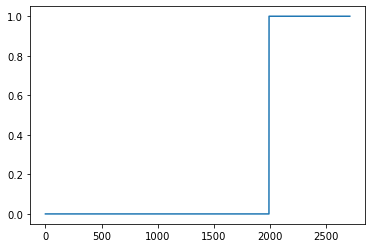

In [ ]:
from scipy import stats

import pandas as pd

from nixtlats.losses.numpy import mae, rmae, smape, rmse
from nixtlats.data.datasets.epf import epf_naive_forecast

Y_naive_df = epf_naive_forecast(Y_df)

# Filter test hours
y_true = y_true[0, -30*24:]
y_hat = y_hat[0, -30*24:]
y_naive = Y_naive_df.y_hat.values[-30*24:]

metrics = pd.Series({'mae' :  mae(y=y_true, y_hat=y_hat),
                     'rmae':  rmae(y=y_true, y_hat1=y_hat, y_hat2=y_naive),
                     'smape': smape(y=y_true, y_hat=y_hat),
                     'rmse':  rmse(y=y_true, y_hat=y_hat)})

print(metrics)
print('\n')
print(stats.describe(y_true-y_hat))
print(f'model.training_percentile {model.training_percentile}')

plt.plot(sample_mask[0,:])
plt.show()

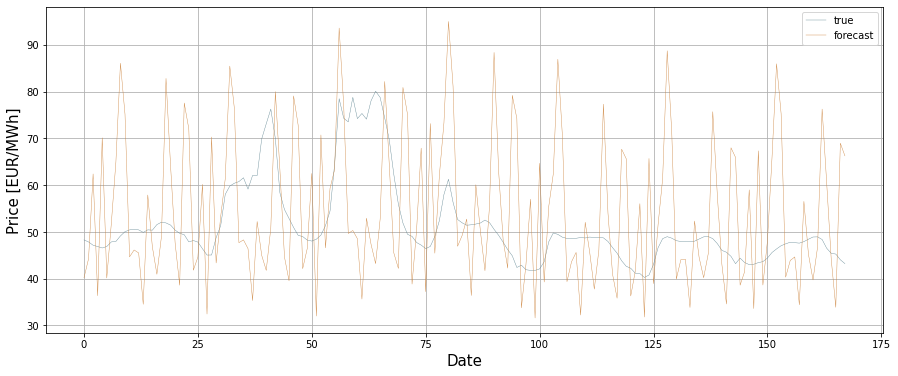

In [ ]:
start = 0
end = 7 * 24

fig = plt.figure(figsize=(15, 6))
plt.plot(y_true[start:end], color='#628793', linewidth=0.4, label='true')
plt.plot(y_hat[start:end], color='peru', linewidth=0.4, label='forecast')
plt.ylabel('Price [EUR/MWh]', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.grid()
plt.show()

## ES-RNN Multivariate Example

In [ ]:
from nixtlats.data.datasets.tourism import Tourism, TourismInfo

group = TourismInfo['Yearly']
print(group.name)
Y_df, *_ = Tourism.load(directory='./data', group=group.name)

Yearly


In [ ]:
fill_uids = Y_df.groupby('unique_id').size().sort_values() \
                .add(-group.horizon-1) \
                .loc[lambda x: x < 2 * group.horizon] \
                .index

In [ ]:
new_ys = []
for uid in fill_uids:
    y = Y_df.query('unique_id == @uid')

    ds_to_fill = 2 * group.horizon - y.shape[0] + group.horizon + 1

    ds = pd.date_range(end = y.iloc[0].ds, periods = ds_to_fill + 1, freq = group.freq)[:ds_to_fill]
    new_y = pd.DataFrame({'ds': ds})
    new_y['unique_id'] = y.iloc[0].unique_id
    new_y['y'] = y.iloc[0].y
    
    new_ys.append(new_y)
new_ys = pd.concat(new_ys)

In [ ]:
Y_df = pd.concat([Y_df, new_ys]).sort_values(['unique_id', 'ds'], ignore_index=True)

In [ ]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=group.horizon,
                                  is_test=False,
                                  input_size=group.horizon,
                                  output_size=group.horizon,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=0,
                                  is_test=True,
                                  input_size=group.horizon,
                                  output_size=group.horizon,
                                  verbose=True)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           1990-12-31 2007-12-31
1           1960-12-31 2003-12-31
INFO:root:
Total data 			12708 time stamps 
Available percentage=100.0, 	12708 time stamps 
Insample  percentage=83.7, 	10636 time stamps 
Outsample percentage=16.3, 	2072 time stamps 

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           1960-12-31 2007-12-31
INFO:root:
Total data 			12708 time stamps 
Available percentage=100.0, 	12708 time stamps 
Insample  percentage=0.0, 	0 time stamps 
Outsample percentage=100.0, 	12708 time stamps 



In [ ]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=1,
                                shuffle=False)

In [ ]:
dataloader = iter(train_loader)
batch = next(dataloader)
S, Y, X = batch['S'], batch['Y'], batch['X']
available_mask = batch['available_mask']
idxs = batch['idxs']

print("S.shape", S.shape)
print("Y.shape", Y.shape)
print("X.shape", X.shape)
print("idxs.shape", idxs.shape)

S.shape torch.Size([32, 0])
Y.shape torch.Size([32, 47])
X.shape torch.Size([32, 0, 47])
idxs.shape torch.Size([32])


In [ ]:
model = ESRNN(n_series=train_dataset.n_series,
              n_s=train_dataset.n_s,
              n_x=train_dataset.n_x,
              input_size=train_dataset.input_size,
              output_size=train_dataset.output_size,
              sample_freq=1,
              learning_rate=5e-3,
              lr_scheduler_step_size=100,
              lr_decay=0.9,
              per_series_lr_multip=1.5,
              gradient_eps=1e-8,
              gradient_clipping_threshold=10,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=10,
              testing_percentile=50,
              training_percentile=51,
              es_component='multiplicative',
              cell_type='GRU',
              state_hsize=50,
              dilations=[[24, 48], [168]],
              add_nl_layer=False,
              loss='SMYL',
              val_loss='MAE',
              seasonality=[1])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=1, verbose=True, 
                               mode="min")

In [ ]:
trainer = pl.Trainer(max_epochs=2, progress_bar_refresh_rate=1, 
                     log_every_n_steps=1, check_val_every_n_epoch=1,
                     callbacks=[early_stopping])
trainer.fit(model, train_loader, valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | model | _ESRNN | 40.8 K
---------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/federicogarza2/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/federicogarza2/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68293.117


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 1 records. Best score: 68293.117. Signaling Trainer to stop.


In [ ]:
outputs = trainer.predict(model, valid_loader)
y, y_hat, mask = zip(*outputs)
y = t.cat(y, axis=1)
y_hat = t.cat(y_hat, axis=1)
mask = t.cat(mask, axis=1)
print("y_true.shape", y.shape)
print("y_hat.shape", y_hat.shape)
print("mask.shape", mask.shape)

/home/federicogarza2/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 17it [00:00, ?it/s]

y_true.shape torch.Size([1, 9082, 4])
y_hat.shape torch.Size([1, 9082, 4])
mask.shape torch.Size([1, 9082, 4])
